In [1]:
import os
import sys
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Dense, Embedding, Input, LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam, SGD

import gensim
from gensim.models.keyedvectors import KeyedVectors

Using TensorFlow backend.


In [2]:
# some config
BATCH_SIZE = 64  # Batch size for training.
EPOCHS = 15  # Number of epochs to train for.
LATENT_DIM = 512  # Latent dimensionality of the encoding space.
NUM_SAMPLES = 20000  # Number of samples to train on.
MAX_SEQUENCE_LENGTH = 100
MAX_NUM_WORDS = 25000
EMBEDDING_DIM = 300  # embedding dimension for word embedding which is given at encoder training

In [3]:
# Read the data
input_texts = []
target_texts = [] # with end token
target_texts_inputs = [] # with start token

In [4]:
count = 0
for line in open("C://Users//dtecitak//Desktop//AdvancedNLP-master//Data//MT//tur.txt", encoding="utf-8"):
    count += 1
    
    if count > NUM_SAMPLES:
        break
    
    if '\t' not in line:
        continue
    
    input_text, output = line.rstrip().split('\t')[:2]
    
    target_text = output + ' <eos>'
    target_text_input = '<sos> '+ output
    
    input_texts.append(input_text) # Erol is a good boy
    target_texts.append(target_text) # Erol iyi bir çocuktur <eos>, decoder output
    target_texts_inputs.append(target_text_input) # <sos> Erol iyi bir çocuktur, decoder input

In [5]:
print("Training Encoder Sample Number: ", len(input_texts))
print("Training Decoder Output Sample Number: ", len(target_texts))
print("Training Decoder Input Sample Number: ", len(target_texts_inputs))

Training Encoder Sample Number:  20000
Training Decoder Output Sample Number:  20000
Training Decoder Input Sample Number:  20000


In [6]:
print(input_texts[0])
print(target_texts[0])
print(target_texts_inputs[0])

Run!
Kaç! <eos>
<sos> Kaç!


In [7]:
#Tokenization Input

# It divides a sentence into the corresponding list of word
# Then it converts the words to integers
tokenizer_inputs = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)

# get the word to index mapping for input language
word2idx_inputs = tokenizer_inputs.word_index
print('Found %s unique input tokens.' % len(word2idx_inputs))

# determine maximum length input sequence
max_len_input = max(len(s) for s in input_sequences)
print("Max sentence length for Input: ",max_len_input)

Found 4668 unique input tokens.
Max sentence length for Input:  7


In [8]:
word2idx_inputs

{'tom': 1,
 'i': 2,
 'you': 3,
 'a': 4,
 'is': 5,
 'the': 6,
 'to': 7,
 'it': 8,
 "i'm": 9,
 'was': 10,
 'do': 11,
 'we': 12,
 'that': 13,
 'my': 14,
 'me': 15,
 'this': 16,
 'are': 17,
 'have': 18,
 'your': 19,
 "don't": 20,
 'not': 21,
 'can': 22,
 'did': 23,
 'in': 24,
 'be': 25,
 'what': 26,
 'he': 27,
 "it's": 28,
 'want': 29,
 'here': 30,
 'like': 31,
 'has': 32,
 'on': 33,
 "tom's": 34,
 'go': 35,
 "i'll": 36,
 'why': 37,
 'how': 38,
 'very': 39,
 'need': 40,
 'all': 41,
 'for': 42,
 'they': 43,
 'us': 44,
 "can't": 45,
 "you're": 46,
 'at': 47,
 'know': 48,
 'now': 49,
 'get': 50,
 'help': 51,
 "isn't": 52,
 'his': 53,
 'good': 54,
 'of': 55,
 "that's": 56,
 'got': 57,
 'with': 58,
 'up': 59,
 'will': 60,
 'no': 61,
 'so': 62,
 "didn't": 63,
 'were': 64,
 "we're": 65,
 'just': 66,
 'an': 67,
 'too': 68,
 'one': 69,
 'who': 70,
 'love': 71,
 'mary': 72,
 'there': 73,
 'home': 74,
 'out': 75,
 'see': 76,
 'where': 77,
 'she': 78,
 'had': 79,
 'work': 80,
 'look': 81,
 'car': 82,


In [9]:
word2idx_inputs.get('run')

244

In [10]:
# Tokenize Outputs

# don't filter out special characters
# otherwise <sos> and <eos> won't appear
tokenizer_outputs = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
tokenizer_outputs.fit_on_texts(target_texts + target_texts_inputs)
target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
target_sequences_input = tokenizer_outputs.texts_to_sequences(target_texts_inputs)

# get the word to index mapping for output language
word2idx_outputs = tokenizer_outputs.word_index
print('Found %s unique output tokens.' % len(word2idx_outputs))

# store number of output words for later
# remember to add 1 since indexing starts at 1
num_words_output = len(word2idx_outputs) + 1

# determine maximum length output sequence
max_len_target = max(len(s) for s in target_sequences)
print("Max sentence length for Output: ",max_len_target)

Found 14121 unique output tokens.
Max sentence length for Output:  9


In [11]:
# pad the sequences
encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input)
print("encoder_inputs.shape:", encoder_inputs.shape)
print("encoder_inputs[0]:", encoder_inputs[0])

decoder_inputs = pad_sequences(target_sequences_input, maxlen=max_len_target, padding='post')
print("decoder_inputs[0]:", decoder_inputs[0])
print("decoder_inputs.shape:", decoder_inputs.shape)

decoder_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')
print("decoder_outputs[0]:", decoder_targets[0])
print("decoder_outputs.shape:", decoder_targets.shape)

encoder_inputs.shape: (20000, 7)
encoder_inputs[0]: [  0   0   0   0   0   0 244]
decoder_inputs[0]: [   2 3067    0    0    0    0    0    0    0]
decoder_inputs.shape: (20000, 9)
decoder_outputs[0]: [3067    1    0    0    0    0    0    0    0]
decoder_outputs.shape: (20000, 9)


In [12]:
word2idx_outputs["<eos>"]

1

In [13]:
# Load Word Vectors
print("loading word2vec model…")
word2vec_model = KeyedVectors.load_word2vec_format('C:\\Word2Vec_Models\\GoogleNews-vectors-negative300.bin', binary=True)

loading word2vec model…


In [14]:
def getVector(str):
    if str in word2vec_model:
        return word2vec_model[str]
    else:
        return None
    
def isInModel(str):
    return str in word2vec_model

In [15]:
# Prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) +1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx_inputs.items():
    embedding_vector = getVector(word)
    
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [16]:
embedding_matrix.shape

(4669, 300)

In [17]:
# Create embedding layer
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=max_len_input,
)

In [18]:
# create targets, since we cannot use sparse
# categorical cross entropy when we have sequences
decoder_targets_one_hot = np.zeros(
  (
    len(input_texts),
    max_len_target,
    num_words_output
  ),
  dtype='float32'
)

# assign the values
for i, d in enumerate(decoder_targets):
    for t, word in enumerate(d):
        decoder_targets_one_hot[i, t, word] = 1

In [19]:
# Each target has 9 maximum length and Turkish has 
# 14122 words in Turkish vocabulary
# with 20000 training samples
decoder_targets_one_hot.shape

(20000, 9, 14122)

In [20]:
# Build the Model
encoder_inputs_placeholder = Input(shape=(max_len_input,))
x = embedding_layer(encoder_inputs_placeholder)

encoder = LSTM(LATENT_DIM, return_state=True)
encoder_outputs, h, c = encoder(x)

# keep only the states to pass into decoder
encoder_states = [h, c]

In [21]:
# Set up the decoder, using [h, c] as initial state.
decoder_inputs_placeholder = Input(shape=(max_len_target,))

# this word embedding will not use pre-trained vectors
# although you could
decoder_embedding = Embedding(num_words_output, LATENT_DIM)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

# since the decoder is a "to-many" model we want to have
# return_sequences=True
decoder_lstm = LSTM(LATENT_DIM, return_sequences=True, return_state=True)

decoder_outputs, _, _ = decoder_lstm(
  decoder_inputs_x,
  initial_state=encoder_states
)

# final dense layer for predictions
# num_words_output = how many words in Turkish language side
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [22]:
# Create the model object
model = Model([encoder_inputs_placeholder, decoder_inputs_placeholder], decoder_outputs)

In [23]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 7)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 9)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 7, 300)       1400700     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 9, 512)       7230464     input_2[0][0]                    
____________________________________________________________________________________________

In [24]:
# Compile the model and train it
model.compile(
  optimizer='rmsprop',
  loss='categorical_crossentropy',
  metrics=['accuracy']
)

In [25]:
r = model.fit(
  [encoder_inputs, decoder_inputs], decoder_targets_one_hot,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=0.2,
)

C:\Users\dtecitak\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 16000 samples, validate on 4000 samples
Epoch 1/15
16000/16000 [==============================] - 220s 14ms/step - loss: 2.6898 - accuracy: 0.6790 - val_loss: 2.8383 - val_accuracy: 0.6506
Epoch 2/15
16000/16000 [==============================] - 222s 14ms/step - loss: 2.1198 - accuracy: 0.7264 - val_loss: 2.5516 - val_accuracy: 0.6808
Epoch 3/15
16000/16000 [==============================] - 230s 14ms/step - loss: 1.8494 - accuracy: 0.7546 - val_loss: 2.4073 - val_accuracy: 0.6966
Epoch 4/15
16000/16000 [==============================] - 240s 15ms/step - loss: 1.6683 - accuracy: 0.7748 - val_loss: 2.3189 - val_accuracy: 0.7092
Epoch 5/15
16000/16000 [==============================] - 230s 14ms/step - loss: 1.5297 - accuracy: 0.7905 - val_loss: 2.2714 - val_accuracy: 0.7166
Epoch 6/15
16000/16000 [==============================] - 228s 14ms/step - loss: 1.4140 - accuracy: 0.8046 - val_loss: 2.2657 - val_accuracy: 0.7161
Epoch 7/15
16000/16000 [==============================] -

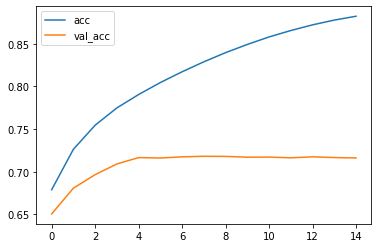

In [26]:
# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

# Save model
model.save('MT_S2S.h5')

In [27]:
##### Make predictions #####
# As with the poetry example, we need to create another model
# that can take in the RNN state and previous word as input
# and accept a T=1 sequence.

# The encoder will be stand-alone
# From this we will get our initial decoder hidden state
encoder_model = Model(encoder_inputs_placeholder, encoder_states)

decoder_state_input_h = Input(shape=(LATENT_DIM,))
decoder_state_input_c = Input(shape=(LATENT_DIM,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
# decoder_states_inputs = [decoder_state_input_h] # gru

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

# this time, we want to keep the states too, to be output
# by our sampling model
decoder_outputs, h, c = decoder_lstm(
  decoder_inputs_single_x,
  initial_state=decoder_states_inputs
)
# decoder_outputs, state_h = decoder_lstm(
#   decoder_inputs_single_x,
#   initial_state=decoder_states_inputs
# ) #gru
decoder_states = [h, c]
# decoder_states = [h] # gru
decoder_outputs = decoder_dense(decoder_outputs)

# The sampling model
# inputs: y(t-1), h(t-1), c(t-1)
# outputs: y(t), h(t), c(t)
decoder_model = Model(
  [decoder_inputs_single] + decoder_states_inputs, 
  [decoder_outputs] + decoder_states
)

# map indexes back into real words
# so we can view the results
idx2word_eng = {v:k for k, v in word2idx_inputs.items()}
idx2word_trans = {v:k for k, v in word2idx_outputs.items()}

In [28]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

    # Populate the first character of target sequence with the start character.
    # NOTE: tokenizer lower-cases all words
    target_seq[0, 0] = word2idx_outputs['<sos>']

    # if we get this we break
    eos = word2idx_outputs['<eos>']

    # Create the translation
    output_sentence = []
    for _ in range(max_len_target):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
    # output_tokens, h = decoder_model.predict(
    #     [target_seq] + states_value
    # ) # gru

        # Get next word
        idx = np.argmax(output_tokens[0, 0, :])

        # End sentence of EOS
        if eos == idx:
            break

        word = ''
        if idx > 0:
            word = idx2word_trans[idx]
            output_sentence.append(word)

        # Update the decoder input
        # which is just the word just generated
        target_seq[0, 0] = idx

        # Update states
        states_value = [h, c]
        # states_value = [h] # gru

    return ' '.join(output_sentence)

In [29]:
while True:
    # Do some test translations
    i = np.random.choice(len(input_texts))
    input_seq = encoder_inputs[i:i+1]
    translation = decode_sequence(input_seq)
    
    print('-')
    print('Input:', input_texts[i])
    print('Translation:', translation)

    ans = input("Continue? [Y/n]")
    if ans and ans.lower().startswith('n'):
        break

-
Input: My neighbor is crazy.
Translation: karım çok ben benim verdi.
Continue? [Y/n]y
-
Input: I have a maid.
Translation: bir kardeşim var.
Continue? [Y/n]y
-
Input: Tom sings at church.
Translation: tom şarkı şarkı söyler.
Continue? [Y/n]y
-
Input: He begged for his life.
Translation: onun adamdır.
Continue? [Y/n]y
-
Input: The rain has stopped.
Translation: yağmur yağmur yağmur
Continue? [Y/n]y
-
Input: Now's my chance.
Translation: şimdi benim şimdi değil.
Continue? [Y/n]y
-
Input: Lighten up, guys.
Translation: siz de tom'un bizimle tut.
Continue? [Y/n]y
-
Input: Ask Tom what he wants.
Translation: tom'a ne tom'a sor.
Continue? [Y/n]y
-
Input: Tom closed it.
Translation: tom kapattı.
Continue? [Y/n]y
-
Input: How's your mother, Tom?
Translation: senin tom'a nasıl?
Continue? [Y/n]y
-
Input: Tom can't stand up.
Translation: tom ayağa ayağa kadar burada
Continue? [Y/n]y
-
Input: I saw Tom wink at you.
Translation: tom'u için tom'u gördüm.
Continue? [Y/n]y
-
Input: Is this my wine?
